In [28]:
from pystac import Catalog
from pathlib import Path
from shapely import Point, Polygon
import xarray as xr
from pyproj import Transformer
import stmtools
import geopandas as gpd
import numpy as np
import dask_geopandas as dg
import pandas as pd

In [2]:
catalog_path = Path('./data/catalog/catalog.json')
catalog = Catalog.from_file(catalog_path)

In [3]:
example_stm = xr.open_zarr('./download/stm_example.zarr')
example_stm

<xarray.Dataset>
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    range      (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    complex    (space, time) complex64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    phase      (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [4]:
bbox_stm_wgs84 = [
    example_stm["lon"].values.min(),
    example_stm["lat"].values.min(),
    example_stm["lon"].values.max(),
    example_stm["lat"].values.max(),
]
bbox_stm_wgs84

[4.7981586, 52.250504, 4.976751, 52.470882]

In [5]:
# Transform to RD
transformer = Transformer.from_crs("EPSG:4326", "EPSG:28992")
bbox_stm_rd = [
    *transformer.transform(bbox_stm_wgs84[1], bbox_stm_wgs84[0]),
    *transformer.transform(bbox_stm_wgs84[3], bbox_stm_wgs84[2])
]
bbox_stm_rd

[114775.61921292896, 473769.9741285362, 127109.96237056024, 498206.0458581245]

In [6]:
# Create search polygon from bounding box
polygon_search = Polygon(
    [
        (bbox_stm_rd[0], bbox_stm_rd[1]),
        (bbox_stm_rd[0], bbox_stm_rd[3]),
        (bbox_stm_rd[2], bbox_stm_rd[3]),
        (bbox_stm_rd[2], bbox_stm_rd[1]),
    ]
)

In [7]:
# Iterate over the items in the catalog
items = []
for item in catalog.get_all_items():
    # Check if the item intersects with the point
    bbox = item.bbox
    polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1])])
    if polygon_search.intersects(polygon):
        items.append(item)
items

[<Item id=bag>, <Item id=knmi>]

In [8]:
# Get the data path
# This path can be used in stmtools.stm.enrich_from_polygon() function to perform enrichment
data_paths =  [Path(item.assets['data'].href) for item in items]
data_paths

[PosixPath('/home/oku/Developments/MobyLe/example_scripts/stac_catalog/data/bag.parquet'),
 PosixPath('/home/oku/Developments/MobyLe/example_scripts/stac_catalog/data/knmi.zarr')]

In [9]:
# Inspect which columns are available
items[0].properties['columns']

['rdf_seealso',
 'identificatie',
 'bouwjaar',
 'status',
 'gebruiksdoel',
 'oppervlakte_min',
 'oppervlakte_max',
 'aantal_verblijfsobjecten',
 'geometry']

In [10]:
# Query the bag polygon "bouwjaar" to STM
ddf_bag = dg.read_parquet(data_paths[0], columns=["bouwjaar", "geometry"])
bag_polygons = ddf_bag.get_partition(0).compute().cx[bbox_stm_rd[0]:bbox_stm_rd[2], bbox_stm_rd[1]:bbox_stm_rd[3]]
for i in range(ddf_bag.npartitions):
    new = ddf_bag.get_partition(i)[["bouwjaar", "geometry"]].compute().cx[bbox_stm_rd[0]:bbox_stm_rd[2], bbox_stm_rd[1]:bbox_stm_rd[3]]
    bag_polygons = pd.concat([bag_polygons, new])

bag_polygons = bag_polygons.to_crs(4326)

stm_enriched = example_stm.stm.enrich_from_polygon(bag_polygons, ["bouwjaar"])
stm_enriched

<xarray.Dataset>
Dimensions:    (time: 10, space: 78582)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    azimuth    (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    range      (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    complex    (space, time) complex64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    phase      (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    bouwjaar   (space) object dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [50]:
# Points not on BAG polygons will be None
# Drop entries with None values to exclude them
mask = (stm_enriched['bouwjaar'] == None)
stm_enriched_subset = stm_enriched.where(~mask.compute(),drop=True)
stm_enriched_subset

<xarray.Dataset>
Dimensions:    (space: 26267, time: 10)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    azimuth    (space) int64 100 102 102 102 102 ... 1799 1799 1799 1799 1799
    lat        (space) float32 52.25 52.25 52.25 52.26 ... 52.46 52.46 52.46
    lon        (space) float32 4.89 4.881 4.89 4.915 ... 4.816 4.817 4.817 4.817
    range      (space) int64 1475 1314 1472 1904 1914 ... 1312 1322 1326 1328
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 dask.array<chunksize=(153, 10), meta=np.ndarray>
    complex    (space, time) complex64 dask.array<chunksize=(153, 10), meta=np.ndarray>
    phase      (space, time) float32 dask.array<chunksize=(153, 10), meta=np.ndarray>
    bouwjaar   (space) object dask.array<chunksize=(153,), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

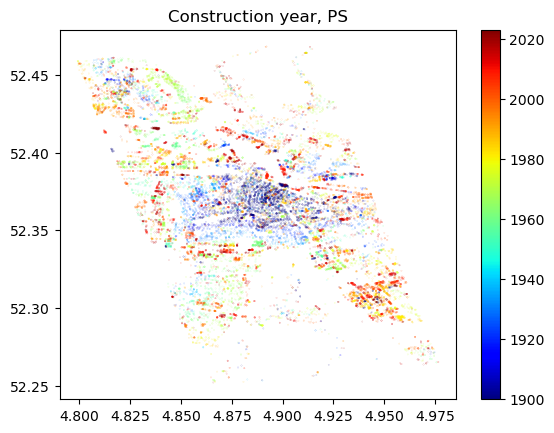

In [51]:
# Visualize results
from matplotlib import pyplot as plt
import matplotlib.cm as cm

colormap = cm.jet

fig, ax = plt.subplots()
plt.title("Construction year, PS")
plt.scatter(stm_enriched_subset.lon.data, stm_enriched_subset.lat.data, c=stm_enriched_subset['bouwjaar'], s=0.004, cmap=colormap)
plt.clim([1900, 2023])
plt.colorbar()